# Convolutional Neural Network for Classification of Breast Cancer Cells

### **Authors**: Aaron Cherry

## Overview

The purpose of this study is to train a Convolutional Neural Network (CNN) to identify and classify cancerous cells in needle biopsy images. The aim is to develop a model that distinguishes cancerous regions from non-cancerous regions in whole slide images (WSI) of invasive ductal carcinoma (IDC).

## Problem Statement

> Around the world, breast cancer annually affects about 1.7 million women. Compared to other
types of cancer, it is the highest recurrent cause of death. Based on collected data by the American
Cancer Society, approximately 268,600 new cases were diagnosed as invasive breast cancer patients
in 2019. In the same year, there were approximately 62,930 new cases of in-situ breast cancer identified,
with roughly 41,760 expected death cases due to breast cancer. Early diagnosis of breast cancer is
significant as a means to boost the number of survivors. The high cost of breast cancer diagnosis and
high morbidity have motivated researchers to explore solutions to develop more precise models for
cancer diagnosis.
~ Alzubaidi et. al. electronics (2019)

The screening and testing process for breast cancer is a long and expensive one. A process that can be augmented by the utilization of Machine Learning and deep neural network models. The importance of implementing CNNs in this field is epitimized by the number of models built and the teams working on the issue such a Google, MIT, and international cooperative efforts like [this study](https://www.mdpi.com/2079-9292/9/3/445). These models include [AlexNet](https://en.wikipedia.org/wiki/AlexNet), [GoogleNet](https://towardsdatascience.com/deep-learning-googlenet-explained-de8861c82765), [ResNet](https://arxiv.org/abs/1512.03385), and [DenseNet](https://arxiv.org/abs/1608.06993). Although there have been many different efforts in research on this specific problem, there are still barriers to deploying working models in the field, mostly building a trust in the community to use such models in machine aided pathology which can be solved by showing results of high accuracy and consistancy in the Neural Networks that have been developed.

## Product Proposal

The following report outlines preliminary work on a Convolutional Neural Network (CNN) designed to predict cancerous regions in Whole Slide Images (WSI). The work underlined in this technical report does not aim to produce better results than models developed by research groups listed above, but to present a light weight solution designed for quick implementation. As a proof of concept, the best model, found through the CRISPR process is used in a web application (repo found [here](https://github.com/JCherryA050/cnn_dp_app)) that functions as a preliminary construct for use in the field.

## Data

The data used in this study comes from Kaggle and can be found [here](https://www.kaggle.com/paultimothymooney/breast-histopathology-images). The data consisits of 162 whole mount slide images of Breast Cancer (BCa) specimens scanned at 40x. The images were then split into 50x50 pixel patches giving 277,524 patches in total. The patches are classified as '0' for IDC-negative and '1' for IDC-positive. The classification process is done through conventional analysis and is based on common features such as count (e.g., mitotic events), segmentation (e.g., nuclei), and tissue classification (e.g., cancerous vs. non-cancerous). An outline of the process and some pitfalls of the analysis technique can be found in [this](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4977982/) publication. The file naming convention is as follows:

> Each patch’s file name is of the format: uxXyYclassC.png — > example 10253idx5x1351y1101class0.png . Where u is the patient ID (10253idx5), X is the x-coordinate of where this patch was cropped from, Y is the y-coordinate of where this patch was cropped from, and C indicates the class where 0 is non-IDC and 1 is IDC.
~ Kaggle Source

The files are contained in a directory system separated by whole slide scan with subdirectories separating the files into 0-IDCnegative, and 1-IDCpositive.

## Data Preperation

The data is separated by scan with subfolders define the image label. Before the keras models can be fit and evaluated on the data, train,validation,and test folders need to be made so that ImageGenerators can be defined. The preprocessing of the data is handeled in [data_preprocessing]('../working_notebooks/data_preprocessing.ipynb). In this notebook the following preprocessing steps are taken.

- Import the data
- Separate the data by label
- Make new directory system
- Store the data in the new folders

If running models on local machine: I suggest creating a data/ folder in the main directory, importing the data into that folder and running the data_preprocessing script defining ```/data/split/``` as the parent directory for the split data. The .gitignore includes the ```data/``` directory as the data size is too large to push.

If running models in Google Colab: I suggest uploading the data zip from [Kaggle](https://www.kaggle.com/paultimothymooney/breast-histopathology-images) to Google Drive and mounting your drive. The command: ```!unzip /content/drive/MyDrive/{zipped folder name}``` can be used to unzip the data. Once unzipped, the data_preprocessing script will work using ```/content/IDC_regular_ps50_idx5/``` as the directory path to the data.

If running models in Kaggle Kernel: I suggest going to the [Kaggle](https://www.kaggle.com/paultimothymooney/breast-histopathology-images) page that contains the data set and starting a new notebook from there. the data_preprocessing notebook can then be uploaded into the instance and should work using ```../input/breast-histopathology-images/IDC_regular_ps50_idx5/``` as the path to the data.

Once the script finishes the directory system should resemble the following layout:

```
├── data
    └── split
        ├── test
            ├── positive
            └── negative
        ├── train
            ├── positive
            └── negative
        └─── validation
            ├── positive
            └── negative
```


### Train-Test-Validation Split

For this study, I used 60% of the data to make up the training data, 20% for the test set, and 20% for the validation set. The breakdown for the  amount of data in each set per class is in the table below.

|Set|%|IDC +|IDC -|
|:------|--------:|--------:|-------:|
|train|60|47277|119,243|
|validation|20|15752|39,747|
|test|20|15757|39,748|

## Exploratory Data Analysis

The following section displays examples of the image data; a report of the data features such as the count per label and histograms of the image data is shown to describe the data features. The necessary libraries are imported as well as the data.

In [8]:
# This section uses the opencv library to show images, the following line will download the necessary libraries into the environment
!pip install opencv-python

In [2]:
# Import standard libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd 

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from keras.models import load_model

from sklearn.model_selection import train_test_split
import random
import os, shutil
from glob import glob

# Import sklearn packages for ROC curves
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

# Importing Pillow for breaking down WSI's for evaluation
from PIL import Image
import cv2

# Load local moduls from src folder
import sys
sys.path.append('./src/')
import eval_plots
import whole_slide_process

In [10]:
# Load the data file paths into data and look at the first 10 paths
data = glob('./data/IDC_regular_ps50_idx5/**/*.png',recursive=True)
data[:10]

['./data/IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1001_class0.png',
 './data/IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1051_class0.png',
 './data/IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1101_class0.png',
 './data/IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1151_class0.png',
 './data/IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1201_class0.png',
 './data/IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1251_class0.png',
 './data/IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1301_class0.png',
 './data/IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1351_class0.png',
 './data/IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1501_class0.png',
 './data/IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1551_class0.png']

### Looking at the number of data points per class

In [11]:
# Separating the IDC-positive and IDC-negative images
class0 = []
class1 = []
for datum in data:
    if datum.endswith('class0.png'):
        class0.append((datum.replace(os.path.basename(datum),''),os.path.basename(datum)))
    else:
        class1.append((datum.replace(os.path.basename(datum),''),os.path.basename(datum)))

In [12]:
# Printing the number of images per label to show any class imbalance
print("There are {} files marked as IDC-negative.".format(len(class0)))
print("There are {} files marked as IDC-positive.".format(len(class1)))


There are 198738 files marked as IDC-negative.
There are 78786 files marked as IDC-positive.


- IDC-negative images compose of approximately 70% of the data. There is a class imbalance in the data and will have to be addressed when fitting CNN models.

### Looking at examples of the data to show differences in cancerous tissue and healthy tissue

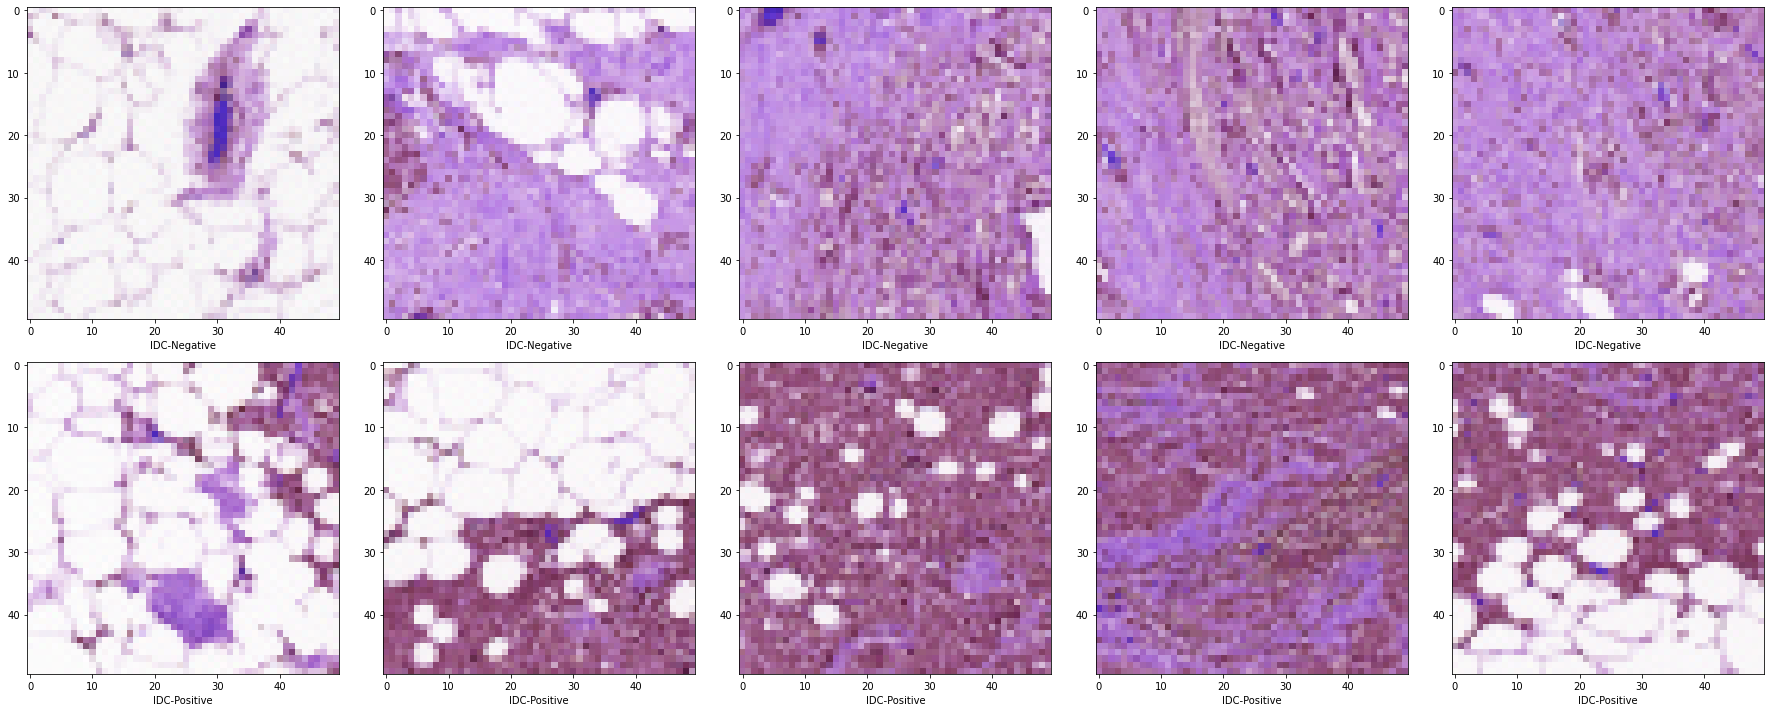

In [13]:
# Look as a sample of the images to get an idea of what the images look like
fig, ax = plt.subplots(2,5,figsize=(25,10))
for i in range(0,5):
    img_1 = class0[i+10]
    img_2 = class1[i+20]

    ax[0][i].imshow(cv2.imread(os.path.join(img_1[0],img_1[1])),cmap='binary')
    ax[0][i].set_xlabel('IDC-Negative')
    ax[1][i].imshow(cv2.imread(os.path.join(img_2[0],img_2[1])),cmap='binary')
    ax[1][i].set_xlabel('IDC-Positive')
    fig.tight_layout()
    fig.savefig('./images/examples.png')


The images seem to have features with different pixel sizes. For example, the tissue dependent features seem to be on a level of 5-10 pixels while some of the more minute details are around 3-5 pixels. The difference in feature sizes should be considered when training and iterating CNNs.

### Looking at the pixel distributions.

In [14]:
neg_red = []
pos_red = []
neg_green = []
pos_green = []
neg_blue = []
pos_blue = []
pos_bright = []
neg_bright = []

for i in random.sample(range(10000),1000):
    img = cv2.imread(os.path.join(class1[i][0],class1[i][1]))
    pos_red.extend(img[:,:,0].flatten().tolist())
    pos_green.extend(img[:,:,1].flatten().tolist())
    pos_blue.extend(img[:,:,2].flatten().tolist())
    pos_bright.extend(img.mean(axis=2).flatten().tolist())
    img2 = cv2.imread(os.path.join(class0[i][0],class0[i][1]))
    neg_red.extend(img2[:,:,0].flatten().tolist())
    neg_green.extend(img2[:,:,1].flatten().tolist())
    neg_blue.extend(img2[:,:,2].flatten().tolist())
    neg_bright.extend(img2.mean(axis=2).

flatten().tolist())

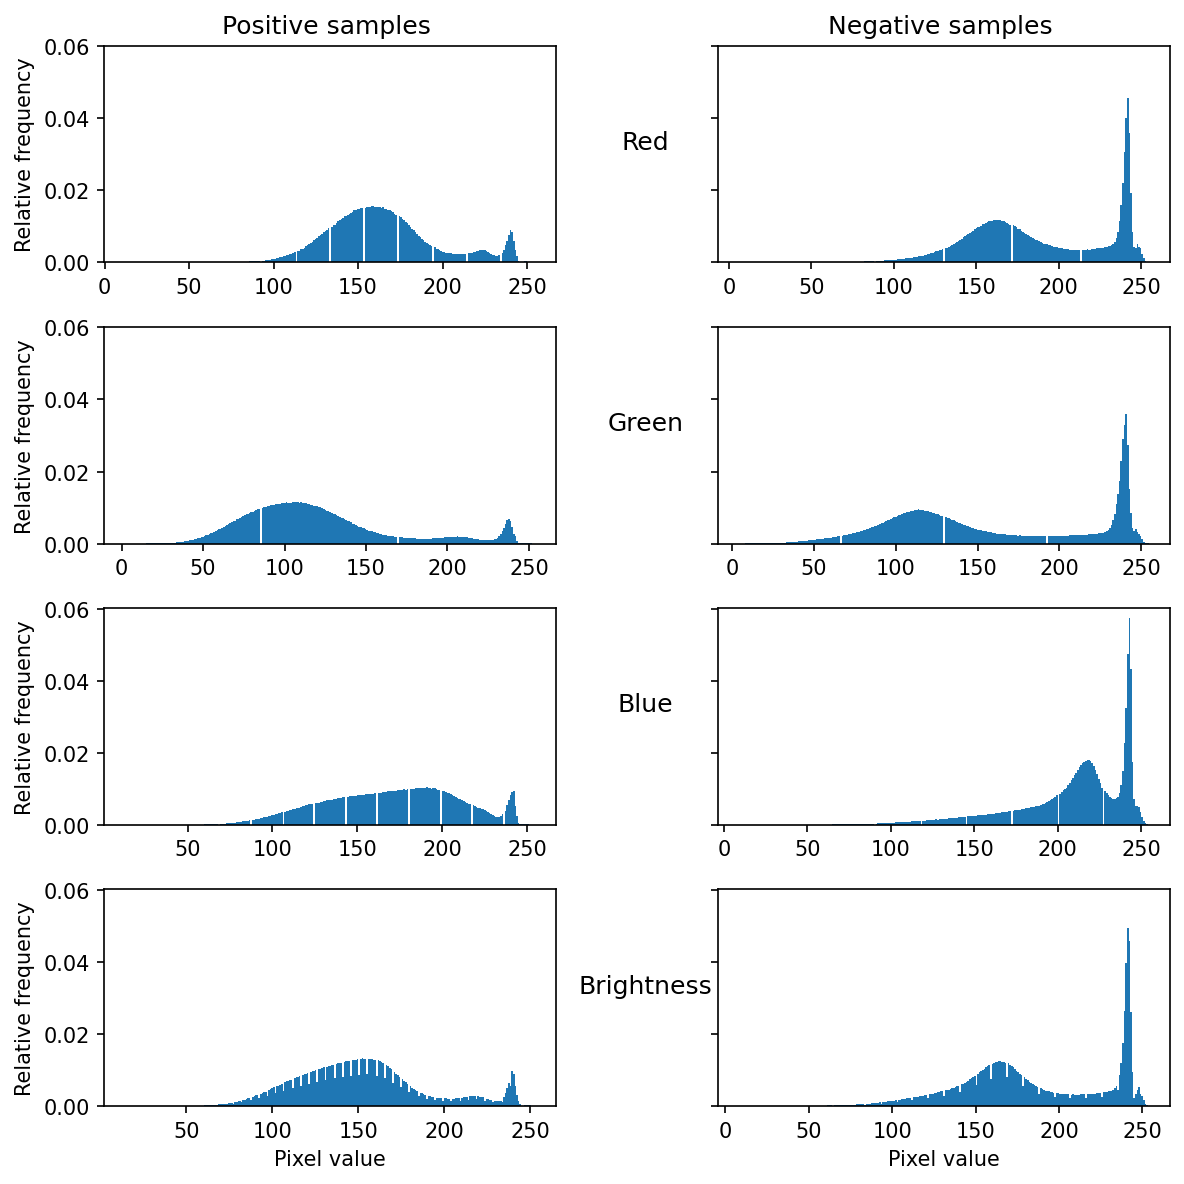

In [15]:
nr_of_bins = 255 #each possible pixel value will get a bin in the following histograms
fig,axs = plt.subplots(4,2,sharey=True,figsize=(8,8),dpi=150)

#RGB channels
axs[0,0].hist(pos_red,bins=nr_of_bins,density=True)
axs[0,1].hist(neg_red,bins=nr_of_bins,density=True)
axs[1,0].hist(pos_green,bins=nr_of_bins,density=True)
axs[1,1].hist(neg_green,bins=nr_of_bins,density=True)
axs[2,0].hist(pos_blue,bins=nr_of_bins,density=True)
axs[2,1].hist(neg_blue,bins=nr_of_bins,density=True)

#All channels
axs[3,0].hist(pos_bright,bins=nr_of_bins,density=True)
axs[3,1].hist(neg_bright,bins=nr_of_bins,density=True)

#Set image labels
axs[0,0].set_title("Positive samples ");
axs[0,1].set_title("Negative samples ");
axs[0,1].set_ylabel("Red",rotation='horizontal',labelpad=35,fontsize=12)
axs[1,1].set_ylabel("Green",rotation='horizontal',labelpad=35,fontsize=12)
axs[2,1].set_ylabel("Blue",rotation='horizontal',labelpad=35,fontsize=12)
axs[3,1].set_ylabel("Brightness",rotation='horizontal',labelpad=35,fontsize=12)
for i in range(4):
    axs[i,0].set_ylabel("Relative frequency")
axs[3,0].set_xlabel("Pixel value")
axs[3,1].set_xlabel("Pixel value")
fig.tight_layout()

### Descriptions of the pixel distributions.


## Modeling

- First Simple Model
- Second Model
- Second Model with L2 regularizations
- Dense Net 201
- Model Comparisons
- Best Model Optimization

All models use the Adam optimizer with a ```binary_crossentropy``` loss function and a learning rate of 1e-5. The accuracy and loss of the model was analyzed for each model to ensure convergence of weights.


### First Simple Model:

The first simple model includes one 2D convolutional layer with a 3x3 filter size and 32 features. A max pooling layer was used with a 2x2 output window. a Dense layer was useed to enumerate the features and then the output layer is set for binary classification. The code below imports the model and prints the summary of the model. If retraining the model from scratch, it is recommended to run the ```fsm_notebook.ipynb```, otherwise the ```fsm.h5``` model can be imported from the ```models/``` directory.

In [16]:
fsm = load_model('./models/fsm.h5')
fsm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               2359424   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 2,360,449
Trainable params: 2,360,449
Non-trainable params: 0
_________________________________________________________________


The FSM is simple because the data itself consists of small images and the differences between cancerous regions and non-cancerous regions were assumed to require less complex features to differentiate. The FSM performed well with an AUC of 0.918 and a test accuracy of 0.84 (with a cutoff value of 0.5).

### First Iteration:

The second model included more complexity by adding three new hidden 2D convolutional layers, one with 64 features and two with 128 features. The goal of added complexity is to define more complex features in the images and to better distinguish between tissues. The kernel size for all of the layers remained at 3x3 to capture smaller features of the images. The following code imports the second model and prints the summary of the model. If retraining the model from scratch, it is recommended to run the ```second_model.ipynb```, otherwise the ```second.h5``` model can be imported from the ```models/``` directory.

In [17]:
first_iteration = load_model('./models/second.h5')
first_iteration.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         1

### First Iteration with Regularization:

The second model seened to overfit on the images as the test accuracy leveled ouut to around 0.92 and the validation/test accuracy was lower (~0.8). The model was having issues with acccuracy converging over epoch number as well which suggested an issue with regularization (according to [this]() source). In the next iteration, an L2 regularization method was implemented for all of the hidden layers with regularization factor of 0.01. The code below loads in the updated model and prints the summary of the model. If retraining the model from scratch, it is recommended to run the 'Regularized' section of ```second_model.ipynb``` , otherwise the ```second_reg.h5``` model can be imported from the ```models/``` directory.

In [3]:
first_iteration_regularized = load_model('./models/second_reg.h5')
first_iteration_regularized.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 128)        

### DenseNet201:

For comparison, the pre-trained model DenseNet201 from the Keras library was trained with an added Dense layer. This model was chosen based on the results of [this](https://iopscience.iop.org/article/10.1088/1742-6596/1651/1/012143/pdf) publication on cancer recognition. The model was run with the ```imagenet``` pretrained weights and an average pooling. The code below imports the model and prints the summary of the model.This model was chosen from the work done by If training the models yourself, it is recommended to to run the ```densenet201.ipynb``` script and save the model to ```/models``` directory.

In [19]:
dn201 = load_model('./models/denseNet201.h5')
dn201.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 1, 1, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               245888    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 18,568,001
Trainable params: 246,017
Non-trainable params: 18,321,984
_________________________________________________________________


### Model Comparrisons

The models were used to predict on the test dataset and the comparisons were made by plotting the ROC curves. First the batch generator is initialized and the test labels are defined.

WARNING: The following code will take several minutes to run.

In [3]:
# set up batch generator for validation set define the path to the test set
test_data_path = './data/split/test'

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
      test_data_path, 
        target_size = (100, 100), 
        batch_size = 32,shuffle=False,class_mode='binary')

# Define list of test labels from test set
y_test = test_generator.labels

Found 16229 images belonging to 2 classes.


Found 16229 images belonging to 2 classes.
Found 16229 images belonging to 2 classes.
Found 16229 images belonging to 2 classes.
Found 16229 images belonging to 2 classes.


<ipython-input-22-4c953430e079>:41: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_rocs(models).show()


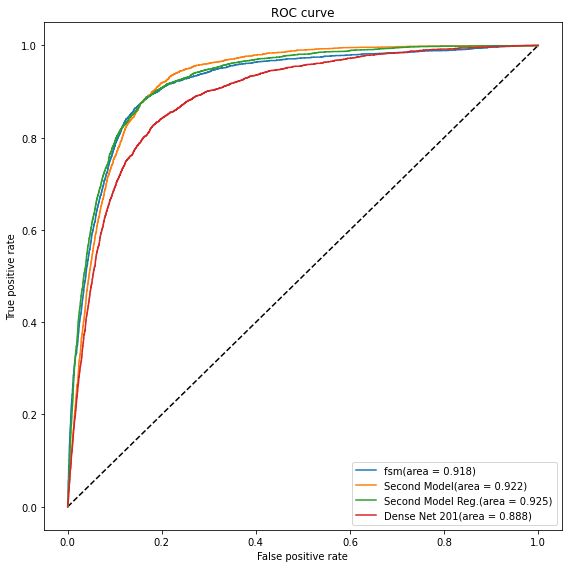

In [22]:
# initializing a list of models to iterate over with their respective target sizes 
models = {'fsm':[fsm,(50,50)],'Second Model':[first_iteration,(100,100)],'Second Model Reg.':[first_iteration_regularized,(100,100)],'Dense Net 201':[dn201,(50,50)]}

def plot_rocs(models):

    # Initialize the figure and plot the 50% line
    fig,ax = plt.subplots(figsize=(8,8))
    ax.plot([0, 1], [0, 1], 'k--')

    # For loop to loop through the models, make predictions for each model and plot the ROC curve
    for k,v in models.items():

        # set up batch generator for validation set define the path to the test set
        test_data_path = './data/split/test'

        # Initializing the test generator using the target size for the model 
        test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_data_path, 
        target_size = v[1], 
        batch_size = 32,shuffle=False,class_mode='binary')

        # Making the predictions on the test set
        probs = v[0].predict(test_generator)
        probs_list = [prob[0] for prob in probs]
        # Calculating the false positive rate and true positive rate
        fpr, tpr, thresholds = roc_curve(y_test, probs_list)

    
        if k == 'Second Model':
            ax.plot(1 - fpr, 1 - tpr, label=k + '(area = {:.3f})'.format(auc(1 - fpr,1 - tpr)))
        else:
            ax.plot(fpr, tpr, label= k + '(area = {:.3f})'.format(auc(fpr, tpr)))

    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('ROC curve')
    ax.legend(loc='best')
    fig.tight_layout()
    fig.savefig('./images/ROC_comparisons.png')
    return fig
plot_rocs(models).show()

### Best Model Evaluation and Predictions

The best model shown in the graph above was the regularized second model with three hidden layers and L2 regularization. The predicions made from the models are confidence values of the image being classified as IDC-Positive. The process of analyzing cancerous tissues requires a skilled technnician wich at the present can not be replaced by a Neural Network and thus falls outside the scope of this project. The aim of applying Neural Networks to digital pathology is to aid in the process by vetting the massive amounts of whole slides seen by technicians to facilitate the process. Thus, the model proposed will vet on whole slide based on the portion of patches with a high probability of a positive classification. The cutoff for the binary classification is taken from the image below of the recall, precision, and f1-score. The cutoff is skewed left to optimize on the Recall of the model as false negatives pose the greatest risk to patients.

In [4]:
# Load in the best model and print the summary
best_model = first_iteration_regularized

# Make predictions with the best model on the test set
probas = best_model.predict(test_generator)

Found 16229 images belonging to 2 classes.


./src\eval_plots.py:141: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = 2*precision*recall / (precision + recall)
./src\eval_plots.py:139: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = cf_matrix[1,1] / sum(cf_matrix[:,1])


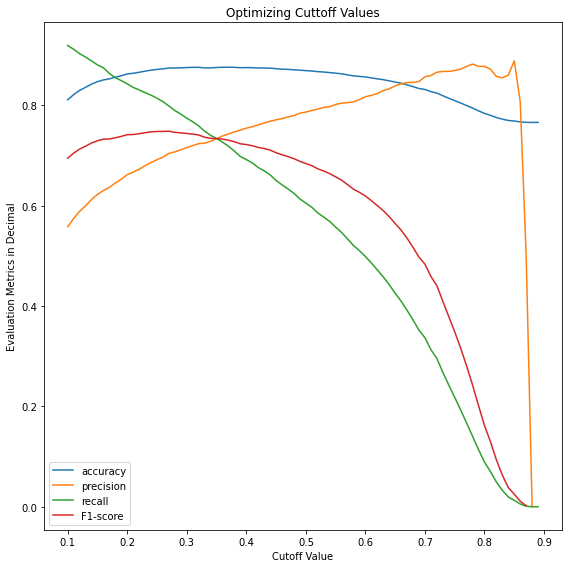

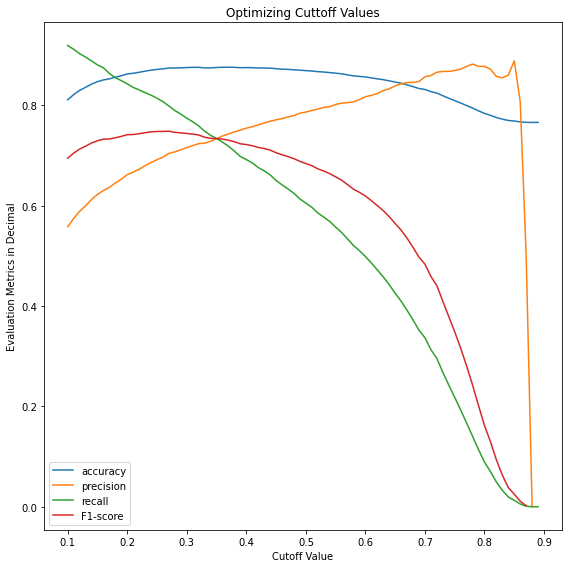

In [5]:
# Initialize array of cutoffs
cuts = np.arange(0.1,0.9,0.01)

# Plot the model metrics as a function of cutoff values
eval_plots.plot_metrics(y_test,probas,cuts)

Optimizing the the recall, a cutoff value of 0.25 was taken. This means that a patch of the scan with a IDC-Positive probability of 25% will be classified as IDC-Positive. Below shows the confusion matrix using this cutoff value. Some accuracy was saccrificed for optimizing the recall.

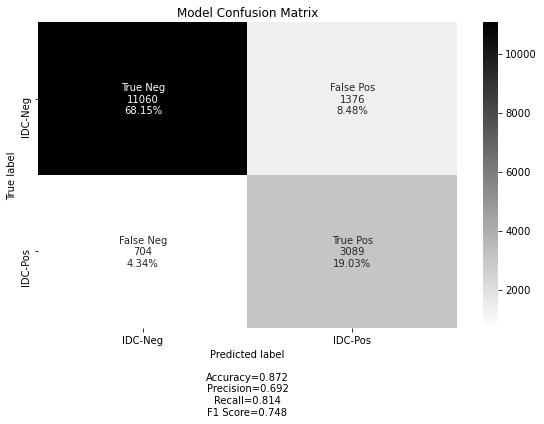

In [6]:
y_predicts = [1 if prob > 0.25 else 0 for prob in probas]
cf_matrix = confusion_matrix(y_test,y_predicts)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['IDC-Neg', 'IDC-Pos']
eval_plots.make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary',
                      figsize=(8,6),title='Model Confusion Matrix')

## Model Predictions

Now that a best model is defined, it can be used in an online application to make predictions on whole slide images. In the following section, the model is used to make predictions on 50x50 patches of a single WSI. The predictions are then analyzed and displayed via a heat map of probabilites/region and a histogram of probabilities.

### Prediction Heat Map
To compare the heat map to the original image and the classes, the ```concat()``` function is used from  ```whole_slide_process.py``` to piece together a whole image from the 50x50 patches in the data.

In [16]:
# Printing out the shole slide from patches in the dataset
whole_slide_process.concat('image','9037',best_model).resize((600,400))

ValueError: max() arg is an empty sequence

In [12]:
# Printing out a map of the labels from the data set for scan 9037
whole_slide_process.concat('class','9037',best_model).resize((600,400))

In [15]:
# Printing out a heat map of the model predictions
whole_slide_process.concat('predict','9037',best_model).resize((600,400))

The heat map shows the probability of IDC-Positive for each patch of the image where black is IDC-negative and white is IDC-Positive, The surrounding white patches are areas where there is no data. The model predicts the actual cancerous regions correctly, however there are some regions that are not classified as cancerous that the model predicts as cancerous. The model, however is inteended to be a preliminary screening, however, and the regions that represent false positives can be corrected by an expert technician.

### Prediction Histogram

The following figure is a histogram of the predictions made on this whole slide. There is a peak around the 0 point and a peak at a higher probability. The second peak represents patches in the WSI that are predicted as IDC-Positive and the macro prediction will be based on the portion of the WSI that have probabilities in this region.

Text(0.5, 1.0, 'Distribution of Prediction Probabilities')

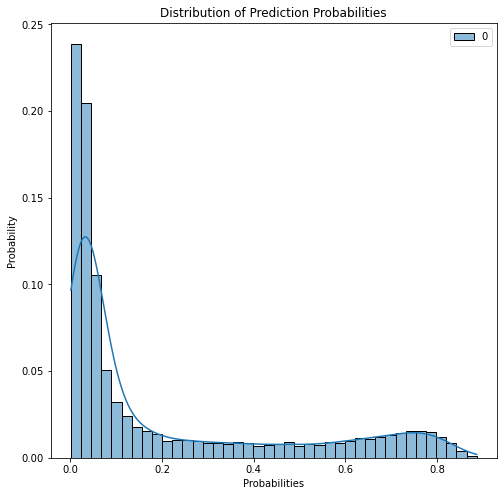

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
sns.histplot(probas,stat='probability',kde=True)
ax.set_xlabel('Probabilities')
ax.set_title('Distribution of Prediction Probabilities')

## Conclusions

A Convolutional Neural Network is proposed for the identification of cancerous regions of whole slide stained biopsy images. Through iteration, the best model performed well with an accuracy of 87.5% and an AUC of 0. The final model was used to predict cancerous regions in an example WSI and was shown to perform well, predicting cancerous regions of the WSI however also giving false positive predictions of non-cancerous regions. This model, however is used as a preliminary screening and the over sensitivity of the model becomes less of an issue when followed up with conventional analysis.

## Next Steps

Model Optimization:
The model shows promise in detecting cancerous regions in WSI analysis, however it is shown to be overly sensitive and falsly predicts IDC-Negative regions in the WSI. Fuuture steps include added complexity of the model to distinguish between these two regions. Future work would benefit from expert feedback and added domain knowlege. The models used in this study are also simplistic in design and may not work well in defining more complex features of the images such as the [nuclear morphology](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4977982/). Future work would include implementing models with an emphasisis on distinguishing more complex features of cancerous cells.

Predicting Cancer Type:
Invasive Ductal Carcinoma is one of for types of malignant cancer. Other malignant cancer types include lobular carcinoma, mucinous carcinoma, and papillary carcinoma. Benign cancers also exist such as adenosis, ficroadenoma, phyllodes tumors, and tubular adenoma. Future work will be dedicated to building more complex models to differentiate between the cancerous types as well as defining cancerous regions within WSIs of each type. For this analysis, data from the [BreakHis](https://www.kaggle.com/ambarish/breakhis) database can be used and contains WSIs of each of the types listed. The data would, however, need to be augmented with images showing only normal tissue. Ideally, the final product would include:

- Prediction of cancerous type
- Probability of WSI showing cancer
- Heat map showing regions of WSI with high probability of being cancerous